# Random Forest Model
This notebook includes the final CV runs of the random forest model for CFPB Complaint Outcomes.

**Note: The data on github is provided in separate pkl files. You can find the narr_df_02.csv here:** https://www.kaggle.com/kharaldsson/cfpb-feature-engineering/output?select=narr_df_02.csv



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


import logging
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
PATH_PARENT = os.path.dirname(os.getcwd())
PATH_RAW = PATH_PARENT + "\\data_raw\\"
PATH_PROC = PATH_PARENT + "\\data_processed\\"

# Import Data + Prep for Models

In [4]:
data_raw = pd.read_csv(PATH_PROC+"narr_df_02.csv"
                       , dtype={"Mulvaney_Dir": "int", "nar_wordct": "int", "nar_charct": "int"
                              , "nar_numerics": "int"
                               }
                      )

C:\ProgramData\Anaconda3\envs\cfpb-kerasgpu-env\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
print(data_raw.shape)
data_raw.head()

(374772, 29)


,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,ZIP_code,Tags,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Consumer_disputed,Complaint_ID,Trump_Admin,Mulvaney_Dir,New_Product,narrative_clean,nar_wordct,nar_charct,nar_numerics,narrative_lemma,narrative_clean_token,narrative_lemma_token,company_clean
0,2019-03-06,Debt collection,Credit card debt,False statements or representation,"Impersonated attorney, law enforcement, or gov...","On XXXX XXXX,2019 my friend got a call from XX...",Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,CA,NaN,NaN,Consent provided,Web,2019-03-07,Closed with explanation,Yes,NaN,3171169,1,1,Debt collection,on 2019 my friend got a call from at becau...,212,1063,8,2019 friend get contact lawyer behalf fr...,"['on', '2019', 'my', 'friend', 'got', 'a', 'ca...","['2019', 'friend', 'get', 'contact', 'lawyer',...",synchrony financial
1,2019-03-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,VA,220XX,NaN,Consent provided,Web,2019-03-05,Closed with explanation,Yes,NaN,3169888,1,1,"Credit reporting, credit repair services, or o...",there are many mistakes appear in my report wi...,11,68,0,mistake appear report understanding,"['there', 'are', 'many', 'mistakes', 'appear',...","['mistake', 'appear', 'report', 'understanding']",experian information solutions inc
2,2019-03-05,Debt collection,Private student loan debt,Attempts to collect debt not owed,Debt is not yours,I HAVE DISPUTED THIS ACCOUNT AND YOU HAVE FAIL...,Company has responded to the consumer and the ...,"Ability Recovery Services, LLC",OK,731XX,NaN,Consent provided,Web,2019-03-05,Closed with explanation,Yes,NaN,3170239,1,1,Debt collection,i have disputed this account and you have fail...,67,407,1,dispute account fail provide validation requir...,"['i', 'have', 'disputed', 'this', 'account', '...","['dispute', 'account', 'fail', 'provide', 'val...",ability recovery services llc
3,2019-03-05,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,This debit was paid however is has been on my ...,Company believes it acted appropriately as aut...,Source Receivables Management LLC,NY,NaN,NaN,Consent provided,Web,2019-03-05,Closed with explanation,Yes,NaN,3170244,1,1,Debt collection,this debit was paid however is has been on my ...,15,68,1,debit pay credit 3 year,"['this', 'debit', 'was', 'paid', 'however', 'i...","['debit', 'pay', 'credit', '3', 'year']",source receivables management llc
4,2019-03-04,Debt collection,Other debt,Written notification about debt,Didn't receive notice of right to dispute,I tried to apply for a car loan and discovered...,Company believes it acted appropriately as aut...,"Waypoint Resource Group, LLC",NM,871XX,NaN,Consent provided,Web,2019-03-08,Closed with explanation,Yes,NaN,3168736,1,1,Debt collection,i tried to apply for a car loan and discovered...,65,336,0,try apply car loan discover bill collection ...,"['i', 'tried', 'to', 'apply', 'for', 'a', 'car...","['try', 'apply', 'car', 'loan', 'discover', 'b...",waypoint resource group llc


In [6]:
"""Select Features"""

# Select Features
data_proc = data_raw[['Company_response_to_consumer', 'Trump_Admin', 'Mulvaney_Dir'
                      , 'New_Product', 'Issue', 'Sub_issue', 'State', 'Company'
                      , 'nar_wordct', 'nar_charct', 'nar_numerics'

                     ]]

# Drop NAs
data_proc = data_proc.dropna(subset=['Company_response_to_consumer'])

# Encode Response Variable
data_proc['label'] = np.where(data_proc['Company_response_to_consumer'] == "Closed with monetary relief", 1, 0)
data_proc = data_proc.drop(columns=['Company_response_to_consumer'])

In [7]:
"""Consolidate Categorical Variable Levels"""

# Top Companies
top_companies = data_proc['Company'].value_counts().nlargest(50).to_frame('counts').reset_index().rename(columns= {'index': 'Company'})

data_proc['Company_Group'] = np.where(data_proc['Company'].isin(top_companies['Company'])
                                      ,data_proc['Company']
                                      ,'Other'
                                     )

data_proc = data_proc.drop(columns=['Company'])

# Limit Levels for other categorical variables before dummy
categorical_ls = ['New_Product', 'Issue', 'Sub_issue', 'State']

def limitLevels(input_df, field_ls, min_perc):
    for field in field_ls:
        levels = input_df[field].value_counts(normalize=True)*100
        levels = levels[levels>min_perc]
        
        input_df[field] = np.where(input_df[field].isin(levels.index), input_df[field], "Other")
    
    return input_df

data_proc = limitLevels(data_proc, categorical_ls, 1) 


print(data_proc.shape)
data_proc.head()

(374768, 11)


,Trump_Admin,Mulvaney_Dir,New_Product,Issue,Sub_issue,State,nar_wordct,nar_charct,nar_numerics,label,Company_Group
0,1,1,Debt collection,False statements or representation,Other,CA,212,1063,8,0,SYNCHRONY FINANCIAL
1,1,1,"Credit reporting, credit repair services, or o...",Incorrect information on your report,Account information incorrect,VA,11,68,0,0,Experian Information Solutions Inc.
2,1,1,Debt collection,Attempts to collect debt not owed,Debt is not yours,Other,67,407,1,0,Other
3,1,1,Debt collection,Attempts to collect debt not owed,Debt was paid,NY,15,68,1,0,Other
4,1,1,Debt collection,Written notification about debt,Didn't receive notice of right to dispute,Other,65,336,0,0,Other


In [8]:
"""Encode Categorical Variables"""

# List of Categorical Variables to Encode
categorical_ls =  ['New_Product', 'Issue', 'Sub_issue', 'State', 'Company_Group']

# Dummy categorical variables
data_final = pd.get_dummies(data_proc, columns=categorical_ls)


print(data_final.shape)
data_final.head()


(374768, 140)


,Trump_Admin,Mulvaney_Dir,nar_wordct,nar_charct,nar_numerics,label,New_Product_Checking or savings account,New_Product_Credit card or prepaid card,"New_Product_Credit reporting, credit repair services, or other personal consumer reports",New_Product_Debt collection,"New_Product_Money transfer, virtual currency, or money service",New_Product_Mortgage,New_Product_Other,"New_Product_Payday loan, title loan, or personal loan",New_Product_Student loan,New_Product_Vehicle loan or lease,"Issue_Account opening, closing, or management",Issue_Attempts to collect debt not owed,Issue_Communication tactics,Issue_Cont'd attempts collect debt not owed,Issue_Credit reporting company's investigation,Issue_Dealing with my lender or servicer,Issue_Dealing with your lender or servicer,Issue_Disclosure verification of debt,Issue_False statements or representation,Issue_Improper use of your report,Issue_Incorrect information on credit report,Issue_Incorrect information on your report,"Issue_Loan modification,collection,foreclosure","Issue_Loan servicing, payments, escrow account",Issue_Managing an account,Issue_Managing the loan or lease,Issue_Other,Issue_Problem with a credit reporting company's investigation into an existing problem,Issue_Problem with a purchase shown on your statement,Issue_Struggling to pay mortgage,Issue_Took or threatened to take negative or legal action,Issue_Trouble during payment process,Issue_Written notification about debt,Sub_issue_Account information incorrect,Sub_issue_Account status,Sub_issue_Account status incorrect,Sub_issue_Account terms,Sub_issue_Attempted to collect wrong amount,Sub_issue_Credit card company isn't resolving a dispute about a purchase on your statement,Sub_issue_Credit inquiries on your report that you don't recognize,Sub_issue_Debt is not mine,Sub_issue_Debt is not yours,Sub_issue_Debt was paid,Sub_issue_Debt was result of identity theft,Sub_issue_Didn't receive enough information to verify debt,Sub_issue_Didn't receive notice of right to dispute,Sub_issue_Frequent or repeated calls,Sub_issue_Information belongs to someone else,Sub_issue_Information is not mine,Sub_issue_Not given enough info to verify debt,Sub_issue_Old information reappears or never goes away,Sub_issue_Other,Sub_issue_Public record,Sub_issue_Public record information inaccurate,Sub_issue_Reporting company used your report improperly,Sub_issue_Their investigation did not fix an error on your report,State_AL,State_AZ,State_CA,State_CO,State_CT,State_FL,State_GA,State_IL,State_IN,State_LA,State_MA,State_MD,State_MI,State_MN,State_MO,State_NC,State_NJ,State_NV,State_NY,State_OH,State_Other,State_PA,State_SC,State_TN,State_TX,State_VA,State_WA,Company_Group_AES/PHEAA,Company_Group_AFNI INC.,Company_Group_ALLY FINANCIAL INC.,Company_Group_AMERICAN EXPRESS COMPANY,Company_Group_Alliance Data Card Services,"Company_Group_BANK OF AMERICA, NATIONAL ASSOCIATION",Company_Group_BARCLAYS BANK DELAWARE,Company_Group_BB&T CORPORATION,Company_Group_CAPITAL ONE FINANCIAL CORPORATION,"Company_Group_CARRINGTON MORTGAGE SERVICES, LLC","Company_Group_CITIBANK, N.A.","Company_Group_CITIZENS FINANCIAL GROUP, INC.","Company_Group_Caliber Home Loans, Inc.","Company_Group_Coinbase, Inc.","Company_Group_Convergent Resources, Inc.",Company_Group_DISCOVER BANK,Company_Group_Ditech Financial LLC,"Company_Group_Diversified Consultants, Inc.",Company_Group_ENCORE CAPITAL GROUP INC.,"Company_Group_EQUIFAX, INC.",Company_Group_ERC,Company_Group_Experian Information Solutions Inc.,Company_Group_FIFTH THIRD FINANCIAL CORPORATION,Company_Group_FREEDOM MORTGAGE COMPANY,Company_Group_HSBC NORTH AMERICA HOLDINGS INC.,"Company_Group_I.C. System, Inc.",Company_Group_JPMORGAN CHASE & CO.,"Company_Group_LoanCare, LLC",Company_Group_NATIONSTAR MORTGAGE,Company_Group_NAVY FEDERAL CREDIT UNION,"Company_Group_NELNET, INC.","Company_Group_National Credit Systems,Inc.","Company_Group_Navient Solutions, LLC.",Company_Group_OCWEN LOAN SERVICING LLC,Company_Group_Other,Company_Gr

In [9]:
"""Binary - Upsample"""
tr, ts = train_test_split(data_final.copy(), test_size = 0.2, random_state=123)

train_minority1 =  tr[tr.label==0]
train_minority2 =  tr[tr.label==1]

len_majority = len(train_minority1)
ls_items = [train_minority2]
tr_up = train_minority1.copy()

for i in ls_items:
    i = resample(i.copy(), replace=True, n_samples=len_majority, random_state=0)
    tr_up = pd.concat([tr_up, i])

X_tr_up = tr_up.copy().drop(columns=[ 'label'])
y_tr_up = tr_up.copy()['label']
X_ts_up = ts.copy().drop(columns=[ 'label'])

y_ts_up = ts.copy()['label']

In [10]:
X_train, y_train = X_tr_up, y_tr_up
X_test, y_test = X_ts_up, y_ts_up

# Random Forest Models

In [12]:
%%time
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [50, 500, 1000]
              , 'max_depth': [5, 10]
              , 'min_samples_split': [5, 10]
}

scoring = {'f1': 'f1', 'AUC': 'roc_auc',  'accuracy': 'accuracy', 'precision': 'precision', 'recall' : 'recall'}

gs_rf_init = RandomForestClassifier(random_state=42)
gs_rf_cv = GridSearchCV(gs_rf_init, parameters, cv=5, n_jobs=-1, verbose=1, scoring=scoring, refit='f1')
gs_rf_cv = gs_rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 46.8min finished


Wall time: 50min 41s


In [18]:
gs_rf_cv_df = pd.DataFrame(gs_rf_cv.cv_results_)
gs_rf_cv_df.sort_values(by=['rank_test_f1'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
7,927.409729,3.493385,34.439090,0.533688,10,5,500,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.822095,0.823558,0.823722,0.824511,0.824278,0.823633,0.000844,1,0.891069,0.891911,0.892636,0.891771,0.892153,0.891908,0.000513,1,0.815090,0.815709,0.815937,0.816309,0.816574,0.815924,0.000512,1,0.792082,0.789922,0.790299,0.789268,0.791054,0.790525,0.000970,1,0.854472,0.860187,0.860096,0.863050,0.860415,0.859644,0.002808,3
10,874.488148,19.277549,29.034146,2.774427,10,10,500,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.822401,0.823758,0.823459,0.823246,0.823558,0.823284,0.000472,2,0.890835,0.891898,0.892528,0.891624,0.891867,0.891750,0.000547,3,0.815320,0.815603,0.815805,0.814974,0.815761,0.815492,0.000310,2,0.792027,0.788876,0.790607,0.788014,0.790118,0.789928,0.001391,2,0.855198,0.861867,0.859159,0.861776,0.859955,0.859591,0.002432,4
8,1622.963034,57.880257,37.693385,3.345165,10,5,1000,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.821906,0.822778,0.823776,0.823614,0.823718,0.823158,0.000723,3,0.891002,0.891819,0.892548,0.891653,0.892068,0.891818,0.000508,2,0.814586,0.815099,0.815946,0.815460,0.815796,0.815378,0.000492,3,0.790686,0.789978,0.790161,0.788762,0.789755,0.789868,0.000633,3,0.855693,0.858419,0.860379,0.861688,0.860733,0.859382,0.002130,5
11,1202.794198,27.463293,23.331614,1.628657,10,10,1000,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.822257,0.822602,0.823213,0.822922,0.823566,0.822912,0.000457,4,0.890934,0.891795,0.892429,0.891542,0.891939,0.891728,0.000491,4,0.815046,0.814807,0.815460,0.814770,0.815778,0.815172,0.000390,4,0.791396,0.789385,0.790020,0.788234,0.790162,0.789839,0.001034,4,0.855622,0.858737,0.859318,0.860804,0.859919,0.858880,0.001767,6
6,93.706374,1.515322,4.042189,0.331105,10,5,50,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.819876,0.821557,0.824422,0.822845,0.823127,0.822365,0.001542,5,0.888266,0.889824,0.890588,0.889688,0.890078,0.889689,0.000775,5,0.811589,0.813242,0.816282,0.814284,0.814894,0.814058,0.001579,5,0.785328,0.786544,0.789445,0.786586,0.788076,0.787196,0.001423,5,0.857603,0.859833,0.862643,0.862607,0.861440,0.860825,0.001909,2
9,94.408110,0.667854,4.061137,0.054597,10,10,50,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.820418,0.820861,0.821637,0.823321,0.821717,0.821591,0.000992,6,0.888300,0.889203,0.890962,0.889802,0.889559,0.889565,0.000865,6,0.811642,0.811907,0.814478,0.813930,0.813294,0.813050,0.001110,6,0.783887,0.783566,0.791111,0.783765,0.786246,0.785715,0.002869,6,0.860521,0.861885,0.854614,0.867082,0.860538,0.860928,0.003974,1
4,478.787689,1.501438,18.719334,0.865828,5,10,500,"{'max_depth': 5, 'min_samples_split': 10, 'n_e...",0.811913,0.811981,0.812421,0.812955,0.813103,0.812475,0.000488,7,0.874541,0.875451,0.877057,0.875567,0.875557,0.875635,0.000808,10,0.801809,0.801128,0.802258,0.802373,0.803151,0.802144,0.000667,7,0.772524,0.769969,0.772709,0.771638,0.773974,0.772163,0.001327,10,0.855534,0.858843,0.856435,0.858947,0.856400,0.857232,0.001396,7
1,480.814472,1.365343,18.146464,0.335367,5,5,500,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.811485,0.811963,0.812256,0.812796,0.813101,0.812320,0.000577,8,0.8

In [56]:
y_pred_gs_rf = gs_rf_cv.predict(X_test)
print('\n Classification Report\n')
print(classification_report(y_test, y_pred_gs_rf))
print(confusion_matrix(y_test, y_pred_gs_rf))


 Classification Report

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     70721
           1       0.18      0.85      0.30      4233

    accuracy                           0.78     74954
   macro avg       0.59      0.81      0.58     74954
weighted avg       0.94      0.78      0.84     74954



In [17]:
import pickle
# save the model to disk
filename = 'gs_rf_cv.sav'
pickle.dump(gs_rf_cv, open(PATH_MODEL+filename, 'wb'))

# Interpretation

In [12]:
%%time

# Fit Best Classifier. Have fit separate model for use with shap package.
rf_1 = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1)
rf_1.fit(X_train, y_train)

Wall time: 1min 26s


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=500,
                       n_jobs=-1, random_state=42)

In [13]:
importances1 = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf_1.feature_importances_,3)})
importances1 = importances1.sort_values('importance',ascending=False).set_index('feature')
importances1.head(25)

,importance
feature,
Issue_Other,0.129
New_Product_Credit card or prepaid card,0.111
New_Product_Checking or savings account,0.107
Sub_issue_Other,0.101
"New_Product_Credit reporting, credit repair services, or other personal consumer reports",0.099
New_Product_Debt collection,0.066
nar_numerics,0.040
"Company_Group_EQUIFAX, INC.",0.028
Issue_Incorrect information on your report,0.022


In [ ]:
%%time
import shap

shap_X_test =  X_test.head(20000)
explainer = shap.TreeExplainer(rf_1, X_train)
shap_values = explainer.shap_values(shap_X_test)
shap.initjs()
shap.summary_plot(shap_values, shap_X_test)

 83%|=================   | 33120/40000 [19:46<04:06]       

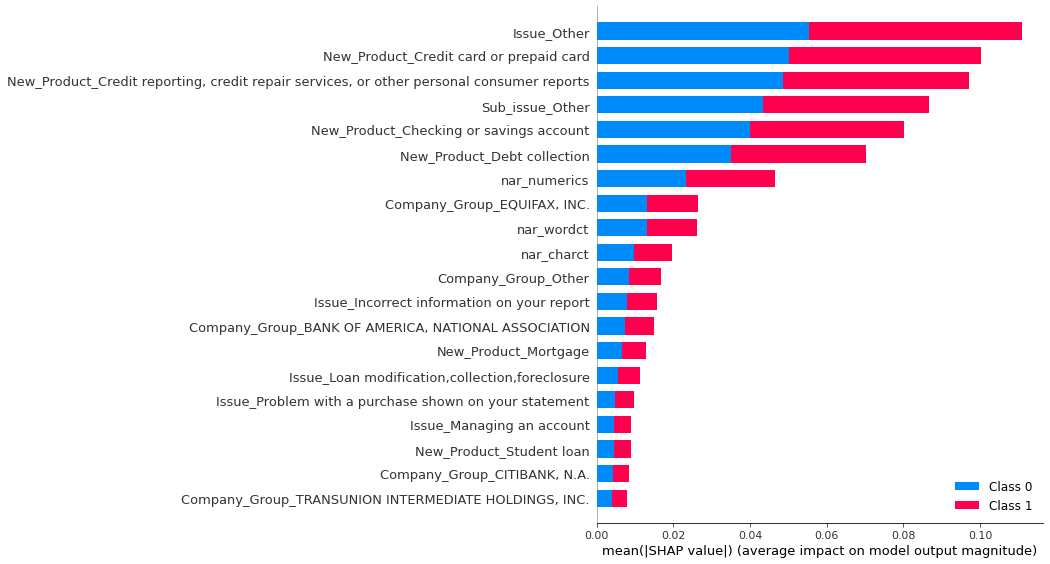

In [16]:
shap.summary_plot(shap_values, shap_X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


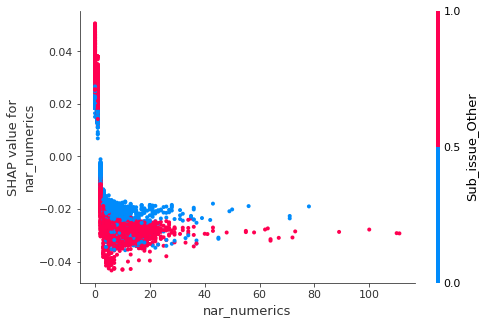

In [18]:
shap.dependence_plot("nar_numerics", shap_values[0], shap_X_test)#, interaction_index='Trump_Admin')

In [52]:
inds = shap.approximate_interactions("Trump_Admin", shap_values[0], shap_X_test)
